# Telegram Analysis

## Prepare environment

In [1]:
"""
Set flag to true, if you work in visual studio code (connected to custom docker)
Set flag to false, if you work in browser (jupyter notebook ui from custom docker)
"""
FLAG_LOCAL              = False
"""
Set flag to true, if you want to work an a spot check (quick run)
"""
FlAG_WORK_ON_SPOT_CHECK = True

In [2]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Import url libs
from urllib.parse import urlparse
from collections import Counter
import requests

# File Handler Lib
from pathlib import Path

# Set graph widget (used by jupyter notebook)
#%matplotlib notebook   #interactive graphs
%matplotlib inline

In [3]:
# Install and import Graph Lib
import networkx as nx
! pip install pydot

In [4]:
# Install and import  JSON Lib
! pip install demjson
import demjson

In [5]:
# Install and import Natural Language Toolkit
! pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Install and import WordCloud
! pip install wordcloud
from wordcloud import WordCloud

In [7]:
# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

In [8]:
# Set env vars
if(FLAG_LOCAL == True):
    dir_var = "./work/notebooks/"
else:
    dir_var = "./"

dir_var_output = dir_var + "output/"

dir_var_cache= dir_var + "cache/"

# Debug output
! echo "- Workdir -"
! ls -al $dir_var

! echo
! echo "- Outputdir -"
! ls -al $dir_var_output

! echo
! echo "- Cachedir -"
! ls -al $dir_var_cache

- Workdir -
total 2092
drwxrwxr-x 6 jovyan  1000    4096 Jan  5 16:21 .
drwxrwxr-x 6 jovyan  1000    4096 Jan  5 15:31 ..
drwxrwxr-x 2 jovyan  1000    4096 Jan  5 16:21 cache
drwxrwxr-x 6 jovyan  1000    4096 Jan  5 15:29 data
-rw-rw-r-- 1 jovyan  1000   11291 Jan  5 15:31 inputFiles.csv
drwxr-xr-x 2 jovyan users    4096 Jan  3 11:12 .ipynb_checkpoints
drwxrwxr-x 2 jovyan  1000    4096 Jan  5 16:21 output
-rwxrwxr-x 1 jovyan  1000 2105329 Jan  5 16:21 Telegram.ipynb

- Outputdir -
total 1148
drwxrwxr-x 2 jovyan 1000   4096 Jan  5 16:21 .
drwxrwxr-x 6 jovyan 1000   4096 Jan  5 16:21 ..
-rw-rw-r-- 1 jovyan 1000      0 Jan  3 10:43 .gitkeep
-rw-rw-r-- 1 jovyan 1000 181385 Jan  5 16:21 meta-overview.png
-rw-rw-r-- 1 jovyan 1000  11362 Jan  5 16:21 meta-text-length-hist.png
-rw-rw-r-- 1 jovyan 1000 457910 Jan  5 16:21 social-graph.png
-rw-rw-r-- 1 jovyan 1000  36026 Jan  5 16:20 social-test-graph.png
-rw-rw-r-- 1 jovyan 1000 472642 Jan  5 16:20 wordcloud-global.png

- Cachedir -
total 144
d

### Global functions

In [9]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

In [10]:
"""
Check if text is json formatted

param   text        InputText
param   singleMode  Boolean (set to true, if text is part of a message)
"""
def gloCheckIsTextJsonFormatted(text, singleMode):
    textString = str(text)
    if      (singleMode == False and textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    elif    (singleMode == True and textString.startswith("{") == True and textString.endswith("}") == True):
        return True
    else:
        return False

In [11]:
# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = chatName.encode('ascii', 'ignore')
    chatName = chatName.decode('ascii')
    return chatName[:30]

In [12]:
# Write dict to file (CSV)
def gloWriteDictToFile(filename, targetDict):
    d = pd.DataFrame.from_dict(targetDict, orient="index")
    d.to_csv(dir_var_cache + filename, header=False)

# Read dict from file (CSV)
def gloReadDictFromFile(filename):
    d = pd.read_csv(dir_var_cache + filename, header=None, index_col=0, squeeze=True)
    return d.to_dict()

# Init csv file if not exists
def gloInitFileDict(filename):
    f = Path(dir_var_cache + filename)
    if(f.exists() == False):
        print("Init cache file >>" + filename + "<<")
        f.touch()
        gloWriteDictToFile(filename, {"initKey": "initValue"})
    else:
        print("Cache already exists >>" + filename + "<<")

In [13]:
# Check if is already cached
def gloCheckIsAlreadyCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    if(targetKey in targetDict.keys()):
        return True
    else:
        return False

# Add key to cache
def gloAddToCache(filename, targetKey, targetValue):
    targetDict = gloReadDictFromFile(filename)
    targetDict[targetKey] = targetValue
    gloWriteDictToFile(filename, targetDict)

# Get key from cache
def gloGetCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    return targetDict[targetKey]

#### Init Cache Files

In [14]:
gloInitFileDict("resolved-urls.csv")

Cache already exists >>resolved-urls.csv<<


## Process input jobs

In [15]:
# Read jobs from file
dfInputFiles = pd.read_csv(dir_var + "inputFiles.csv", sep=";")

In [16]:
# See description above (generate spot check)
if(FlAG_WORK_ON_SPOT_CHECK == True):
    dfFilter = pd.DataFrame()

    # First spot check
    #dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Xavier Naidoo")])
    #dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Oliver Janich")])
    #dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Eva Herman")])
    #dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("ATTILA HILDMANN")])

    # Second spot check
    #dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("FREIHEITS-CHAT")])
    #dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Regellese und Diskussionsgruppe")])
    #dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Unzensiert")])

    # Third spot check
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputDesc == "stage0"])
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputDesc == "stage1"])

    dfInputFiles = dfFilter

### Overview input jobs

In [17]:
dfInputFiles

,inputName,inputPath,inputType,inputId,inputDesc,inputDownloadType
47,ATTILA HILDMANN,DS-05-01-2021/ChatExport_2021-01-05-hildmann,public_channel,10034163583,stage0,onlyText
48,Oliver Janich oeffentlich,DS-05-01-2021/ChatExport_2021-01-05-janich,public_channel,9808932799,stage0,onlyText
49,Eva Herman Offiziell,DS-05-01-2021/ChatExport_2021-01-05-evaherman,public_channel,9915108907,stage0,onlyText
50,Xavier Naidoo (inoffiziell),DS-05-01-2021/ChatExport_2021-01-05-xavier,public_channel,9874390332,stage0,onlyText
51,Gerechtigkeit fuer das Vaterland,DS-05-01-2021a/ChatExport_2021-01-05-gerechtig...,public_channel,10069007089,stage1,onlyText
52,Aktuelle Karikaturen,DS-05-01-2021a/ChatExport_2021-01-05-aktuelleK...,public_channel,9922648130,stage1,onlyText
53,Dr. Heinrich Fiechtner Infokanal,DS-05-01-2021a/ChatExport_2021-01-05-drHeinric...,public_channel,10068827651,stage1,onlyText
54,MICHAEL WENDLER,DS-05-01-2021a/ChatExport_2021-01-05-michaelWe...,public_channel,10067905999,stage1,onlyText
55,Laser Lurch,DS-05-01-2021a/ChatExport_2021-01-05-laserLurch,public_channel,10077326081,stage1,onlyText
56,Dawid Snowden,DS-05-01-2021a/ChatExport_2021-01-05-dawidSnowden,public_channel,9936617855,stage1,onlyText


### Transform data into DataFrmaes

In [18]:
# Convert to DataFrame Meta (Chat Meta)
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + "data/" + filePath + "/result.json", encoding='utf-8')
    return dF

# Convert to DataFrame Messages (Chat Messages)
def convertToDataFrameMessages(filePath, dictMeta):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

In [19]:
"""
Get params from extractedTextData
See cell below (key)
"""
def getExtractedTextDataParam(key, extractedTextData):
    a,b,c,d,e,f,g = extractedTextData
    switcher = {
        0: a,
        1: b,
        2: c,
        3: d,
        4: e,
        5: f,
        6: g
    }
    return switcher.get(key)

In [20]:
# TODO: href, mention and hashtags in normal text?

"""
Extract text data (see cell above key)
See cell above (key)

param   procIsJsonFormatted Boolean (is text json formatted?)
param   text                String  (text from message) 

return
a   procText            Plain Text
b   processedURLs       Array of URLs in Text
c   processedHashtags   Array of Hashtags in Text
d   processedBolds      Array of Bold Items in Text
e   processedItalics    Array of Italic Items in Text
f   processedUnderlines Array of Underlined Items in Text
g   processedEmails     Array of E-Mails in Text
"""
def extractTextData(procIsJsonFormatted, text):
    
    # 3 returns in this function...
    
    processedURLs       = list()
    processedHashtags   = list()
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(procIsJsonFormatted != True):
        #Is not JSON formatted (return normal text)
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is is JSON formatted (try to parse)
        try:
            returnList = []
            jsonList = demjson.decode(str(text), encoding='utf8')

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isJsonSubString = gloCheckIsTextJsonFormatted(messageString, singleMode = True)

                if(isJsonSubString):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        processedHashtags.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unkown json type >>" + str(subJsonType) + "<< (ignore) >>" + str(text) + "<<")

                else:
                    # Is no json formatted sub string (append text)
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            # Parser error (set inputText to returnText)
            print("- Warn: Json parser error (set inputText to returnText) >>" + str(text) + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

In [21]:
def evalIsValidText(procTDTextLength):
    if(procTDTextLength > 0):
        return True
    else:
        return False

In [22]:
def evalContainsSomething(att):
    if(str(att) == "nan"):
        return False
    else:
        return True

In [23]:
gloStartStopwatch("Extract Text Data")

# Add Key = filePath / Value = DataFrame (Chat Meta)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Chat Message)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    gloStartStopwatch("TD-Extract " + fP)
    dfMessages                          = convertToDataFrameMessages(fP, dictMeta)
    
    # Get chat attributes and check if message is json formatted
    dfMessages["procChatFilePath"]      = fP
    dfMessages["procChatType"]          = dictMeta[fP].type.iloc[0]
    dfMessages["procIsJsonFormatted"]   = dfMessages["text"].apply(gloCheckIsTextJsonFormatted, singleMode = False)
    
    # Extract Text Data
    dfMessages["tmpExtractedTD"]        = dfMessages.apply(lambda x: extractTextData(x.procIsJsonFormatted, x.text), axis=1)

    # Extract Text Data (params)
    dfMessages["procTDText"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(0, x.tmpExtractedTD), axis=1)
    dfMessages["procTDURLs"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(1, x.tmpExtractedTD), axis=1)
    dfMessages["procTDHashtags"]        = dfMessages.apply(lambda x: getExtractedTextDataParam(2, x.tmpExtractedTD), axis=1)
    dfMessages["procTDBolds"]           = dfMessages.apply(lambda x: getExtractedTextDataParam(3, x.tmpExtractedTD), axis=1)
    dfMessages["procTDItalics"]         = dfMessages.apply(lambda x: getExtractedTextDataParam(4, x.tmpExtractedTD), axis=1)
    dfMessages["procTDUnderlines"]      = dfMessages.apply(lambda x: getExtractedTextDataParam(5, x.tmpExtractedTD), axis=1)
    dfMessages["procTDEmails"]          = dfMessages.apply(lambda x: getExtractedTextDataParam(6, x.tmpExtractedTD), axis=1)

    # Calc text size
    dfMessages["procTDTextLength"]      = dfMessages["procTDText"].str.len()

    # Add columns (if not exists)
    if "photo" not in dfMessages:
        print("- Debug: Add column >>photo<<")
        dfMessages["photo"] = np.nan

    if "file" not in dfMessages:
        print("- Debug: Add column >>file<<")
        dfMessages["file"] = np.nan

    if "edited" not in dfMessages:
        print("- Debug: Add column >>edited<<")
        dfMessages["edited"] = np.nan

    if "forwarded_from" not in dfMessages:
        print("- Debug: Add column >>forwarded_from<<")
        dfMessages["forwarded_from"] = np.nan

    # Evaluate attributes
    dfMessages["procEvalIsValidText"]   = dfMessages.procTDTextLength.apply(evalIsValidText)
    dfMessages["procEvalContainsPhoto"] = dfMessages.photo.apply(evalContainsSomething)
    dfMessages["procEvalContainsFile"]  = dfMessages.file.apply(evalContainsSomething) 
    dfMessages["procEvalIsEdited"]      = dfMessages.edited.apply(evalContainsSomething)
    dfMessages["procEvalIsForwarded"]   = dfMessages.forwarded_from.apply(evalContainsSomething)
    # TODO: Add more attributes (e.g. procEvalContainBoldItems)
    
    dictMessages[fP] = dfMessages
    gloStopStopwatch("TD-Extract " + fP)

    
# All Messages to DataFrame
gloStartStopwatch("Generate global DataFrame")
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)
gloStopStopwatch("Generate global DataFrame")

gloStopStopwatch("Extract Text Data")

[Stopwatch started >>Extract Text Data<<]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-hildmann<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-hildmann<< (70.724s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-janich<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-janich<< (119.914s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-evaherman<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-evaherman<< (85.006s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-xavier<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-xavier<< (29.298s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-gerechtigkeitVaterland<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-gerechtigkeitVaterland<< (2.846s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-aktuelleKarikat

- Debug: Add column >>file<<
[Stopwatch stopped >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-usWahl2020LiveTicker<< (0.292s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-trueLife<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-trueLife<< (20.623s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-samuelEckert<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-samuelEckert<< (10.047s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-medienKritik<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-medienKritik<< (15.135s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-rabbitResearch<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-rabbitResearch<< (11.311s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-nuoviso<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-nuov

## Meta-Queries

### Type of channels (and only included in)

In [24]:
dfInputFiles.inputType.value_counts()

public_channel       50
public_supergroup     3
Name: inputType, dtype: int64

In [25]:
#dfAllDataMessages.columns.difference(dfAllDataMessages[dfAllDataMessages.procChatType == "public_channel"].dropna(how='all', axis=1).columns)

In [26]:
#dfAllDataMessages.columns.difference(dfAllDataMessages[dfAllDataMessages.procChatType == "public_supergroup"].dropna(how='all', axis=1).columns)

In [27]:
# No enough data
#dfAllDataMessages.columns.difference(dfAllDataMessages[dfAllDataMessages.procChatType == "private_supergroup"].dropna(how='all', axis=1).columns)

### Define queries

In [28]:
def queryChatId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [29]:
def queryChatName(filePath):
    dfMeta      = dictMeta[filePath].copy()
    chatName    = str(dfMeta["name"].iloc[0])
    chatName    = gloConvertToSafeChatName(chatName)
    return chatName

In [30]:
def queryChatType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [31]:
def queryNumberOfMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [32]:
def queryNumberOfFormattedTextMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procIsJsonFormatted == True]
    return len(dfMessages.index)

In [33]:
def queryNumberOfValidTextMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalIsValidText == True]
    return len(dfMessages.index)

In [34]:
def queryNumberOfPhotos(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsPhoto == True]
    return len(dfMessages.index)

In [35]:
def queryNumberOfFiles(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsFile == True]
    return len(dfMessages.index)

In [36]:
def queryNumberOfEditedMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalIsEdited == True]
    return len(dfMessages.index)

In [37]:
def queryNumberOfForwardedMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalIsForwarded == True]
    return len(dfMessages.index)

### Execute queries

In [38]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["qryChatId"]                        = dfQueryMeta.inputPath.apply(queryChatId)
dfQueryMeta["qryChatName"]                      = dfQueryMeta.inputPath.apply(queryChatName)
dfQueryMeta["qryChatType"]                      = dfQueryMeta.inputPath.apply(queryChatType)
dfQueryMeta["qryNumberOfMessages"]              = dfQueryMeta.inputPath.apply(queryNumberOfMessages)
dfQueryMeta["qryNumberOfFormattedTextMessages"] = dfQueryMeta.inputPath.apply(queryNumberOfFormattedTextMessages)
dfQueryMeta["qryNumberOfValidTextMessages"]     = dfQueryMeta.inputPath.apply(queryNumberOfValidTextMessages)
dfQueryMeta["qryNumberOfPhotos"]                = dfQueryMeta.inputPath.apply(queryNumberOfPhotos)
dfQueryMeta["qryNumberOfFiles"]                 = dfQueryMeta.inputPath.apply(queryNumberOfFiles)
dfQueryMeta["qryNumberOfEditedMessages"]        = dfQueryMeta.inputPath.apply(queryNumberOfEditedMessages)
dfQueryMeta["qryNumberOfForwardedMessages"]     = dfQueryMeta.inputPath.apply(queryNumberOfForwardedMessages)

dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False)

,inputPath,qryChatId,qryChatName,qryChatType,qryNumberOfMessages,qryNumberOfFormattedTextMessages,qryNumberOfValidTextMessages,qryNumberOfPhotos,qryNumberOfFiles,qryNumberOfEditedMessages,qryNumberOfForwardedMessages
58,DS-05-01-2021a/ChatExport_2021-01-05-freiheits...,9717909816,FREIHEITS-CHAT,public_supergroup,377365,123812,235454,51116,37522,5091,106025
60,DS-05-01-2021a/ChatExport_2021-01-05-freiheits...,9943834900,FREIHEITSCHAT - BLITZ,public_supergroup,125958,31109,105922,13878,9815,2031,27838
66,DS-05-01-2021a/ChatExport_2021-01-05-einzelfal...,9834356947,Einzelfallinfos,public_channel,51130,51093,51101,0,0,6627,0
48,DS-05-01-2021/ChatExport_2021-01-05-janich,9808932799,Oliver Janich ffentlich,public_channel,47026,32271,31583,7927,6471,4740,16856
47,DS-05-01-2021/ChatExport_2021-01-05-hildmann,10034163583,ATTILA HILDMANN,public_channel,37612,20128,23961,14608,4123,7359,9148
49,DS-05-01-2021/ChatExport_2021-01-05-evaherman,9915108907,Eva Herman Offiziell,public_channel,36523,28401,14107,5509,1978,2762,4949
76,DS-05-01-2021a/ChatExport_2021-01-05-checkMate...,9837468945,CheckMateNews,public_channel,26445,15979,16033,10551,4015,5747,16222
64,DS-05-01-2021a/ChatExport_2021-01-05-jouwatch,9877593062,Jouwatch,public_channel,21137,20910,20916,223,5,0,3
90,DS-05-01-2021a/ChatExport_2021-01-05-augenAuf,10052682051,AugenAuf,public_channel,19148,6535,5893,10655,2673,0,5818
67,DS-05-01-2021a/ChatExport_2021-01-05-qLobalChange,9875095564,Qlobal-Change,public_channel,14945,10715,9242,3918,1586,5592,1864


### Plot meta queries

In [39]:
# Auto label query plot
def autolabelAx(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    Copied from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html (22.12.2020)
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [40]:
def queryMetaPlotter():
    # Init data
    dataLabels                          = list()
    dataNumberOfMesssages               = list()
    dataNumberOfFormattedTextMessages   = list()
    dataNumberOfValidTextMessages       = list()
    dataNumberOfEditedMessages          = list()
    dataNumberOfPhotos                  = list()
    dataNumberOfFiles                   = list()
    dataNumberOfForwardedMessages       = list()

    # Iterate over Meta DataFrame
    for index, row in dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False).iterrows():

        # Get attributes
        dataLabels                          .append(row.qryChatName)
        dataNumberOfMesssages               .append(row.qryNumberOfMessages)
        dataNumberOfFormattedTextMessages   .append(row.qryNumberOfFormattedTextMessages)
        dataNumberOfValidTextMessages       .append(row.qryNumberOfValidTextMessages)
        dataNumberOfEditedMessages          .append(row.qryNumberOfEditedMessages)
        dataNumberOfPhotos                  .append(row.qryNumberOfPhotos)
        dataNumberOfFiles                   .append(row.qryNumberOfFiles)
        dataNumberOfForwardedMessages       .append(row.qryNumberOfForwardedMessages)

    # Convert list to array
    dataLabels                          = np.array(dataLabels)
    dataNumberOfMesssages               = np.array(dataNumberOfMesssages)
    dataNumberOfFormattedTextMessages   = np.array(dataNumberOfFormattedTextMessages)
    dataNumberOfValidTextMessages       = np.array(dataNumberOfValidTextMessages)
    dataNumberOfEditedMessages          = np.array(dataNumberOfEditedMessages)
    dataNumberOfPhotos                  = np.array(dataNumberOfPhotos)
    dataNumberOfFiles                   = np.array(dataNumberOfFiles)
    dataNumberOfForwardedMessages       = np.array(dataNumberOfForwardedMessages)

    # Draw
    fig, ax = plt.subplots()
    x = np.arange(len(dataLabels))

    barWidth = 0.15

    fig.set_figwidth(64)
    fig.set_figheight(16)

    r1 = x
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]
    r7 = [x + barWidth for x in r6]

    rects1 = ax.bar(r1, dataNumberOfMesssages, barWidth, label='Messages')
    rects2 = ax.bar(r2, dataNumberOfFormattedTextMessages, barWidth, label='Formatted Messsages')
    rects3 = ax.bar(r3, dataNumberOfValidTextMessages, barWidth, label='Valid Messages')
    rects4 = ax.bar(r4, dataNumberOfEditedMessages, barWidth, label='Edited Messages')
    rects5 = ax.bar(r5, dataNumberOfPhotos, barWidth, label='with Photo')
    rects6 = ax.bar(r6, dataNumberOfFiles, barWidth, label='with File')
    rects7 = ax.bar(r7, dataNumberOfForwardedMessages, barWidth, label='Forwarded Messages')

    ax.set_ylabel("Count")
    ax.set_title("Meta Overview")
    ax.set_xticks(x)
    ax.set_xticklabels(dataLabels)
    ax.legend()

    rects = [rects1, rects2, rects3, rects4, rects5, rects6, rects7]

    for rect in rects:
        autolabelAx(rect, ax)

    fig.tight_layout()

    plt.xticks(rotation=30)
    plt.savefig(dir_var_output + "meta-overview.png")
    plt.show()

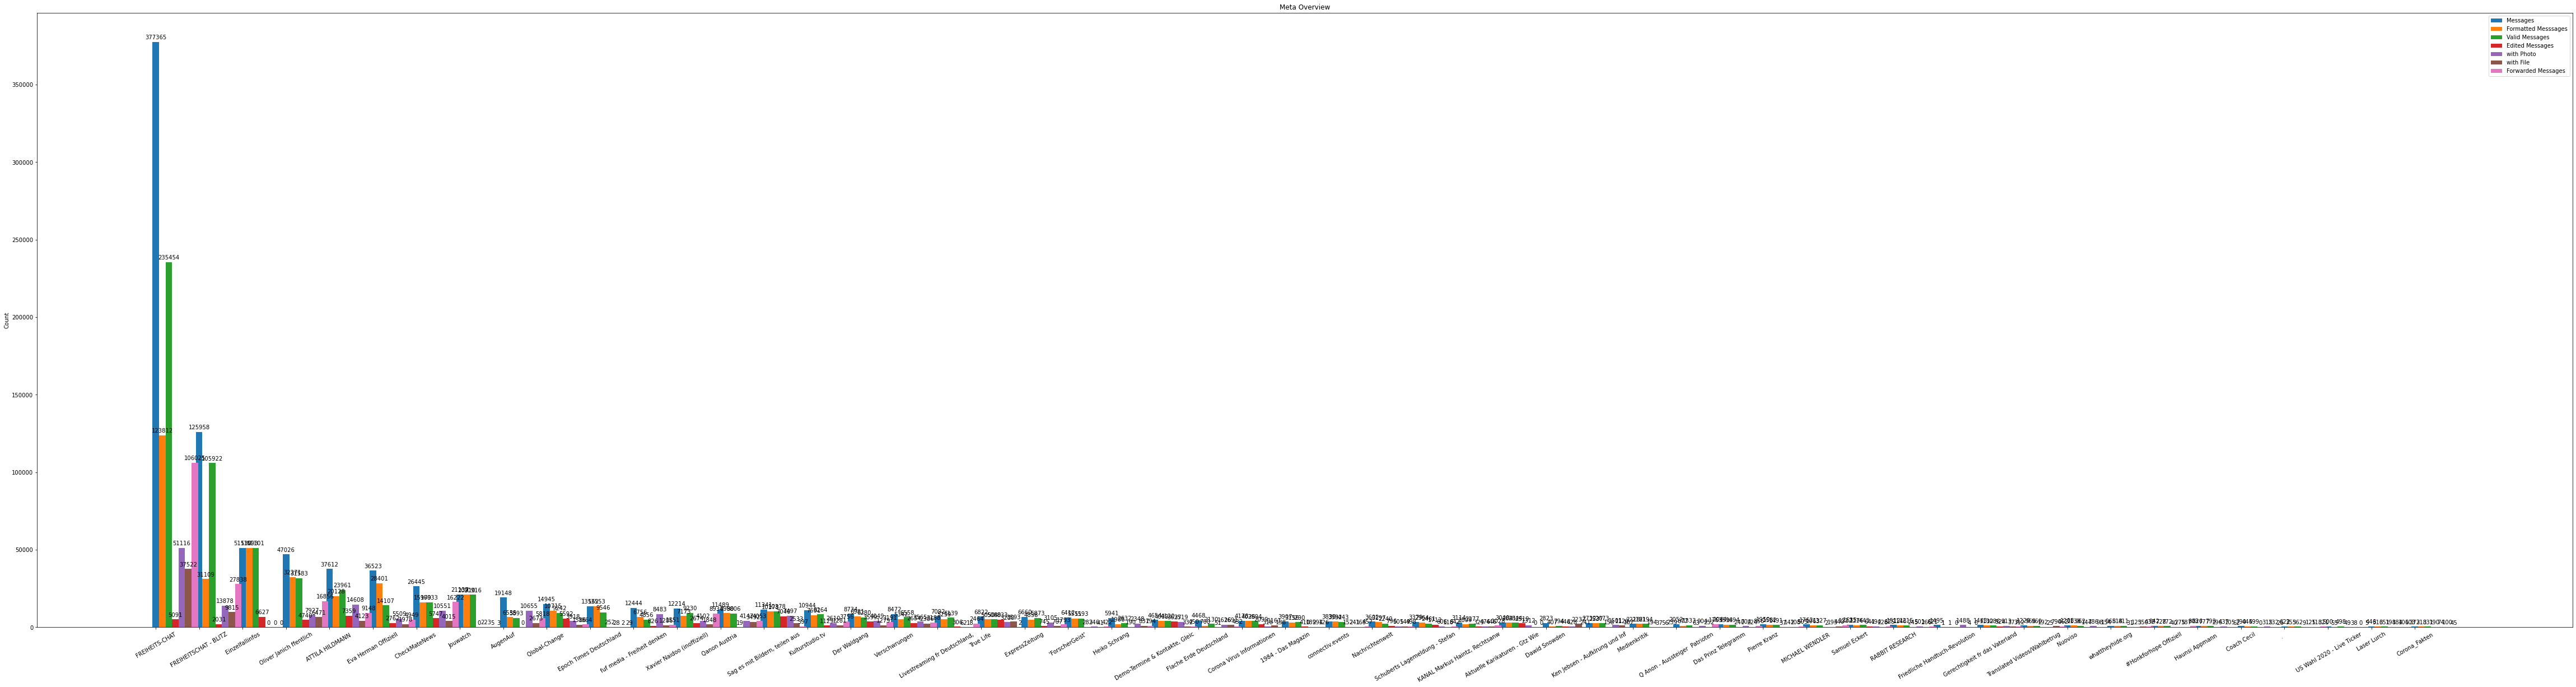

In [41]:
queryMetaPlotter()

### Get text-length

In [42]:
def removeTextLengthOutliersFromDataFrame(df, interval, maxTextLength):
    df = df.copy()
    df = df[df.procTDTextLength < maxTextLength]
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within <interval> to -<interval> standard deviations in the column 'Data'.
    return df[np.abs(df.procTDTextLength-df.procTDTextLength.mean()) <= (interval*df.procTDTextLength.std())]

In [43]:
def textLengthHistPlotter():
    dfMessages = dfAllDataMessages.copy()
    print("Number of all messages:\t\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = dfMessages[dfMessages.procEvalIsValidText == True]
    print("Number of valid text messages:\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = removeTextLengthOutliersFromDataFrame(
        dfMessages,
        interval = 3,               #Default is 3
        maxTextLength = 999999999   #TODO: Maybe enable max text length
        )
    print("Number of valid text messages (after outliers filtering):\t" + str(len(dfMessages.index)))

    print()
    print("Text Length Hist (after outliers filtering)")
    plt.figure(figsize=(16,9))
    _ = dfMessages.procTDTextLength.hist(bins=40)

    plt.savefig(dir_var_output + "meta-text-length-hist.png")

Number of all messages:						943153
Number of valid text messages:					651936
Number of valid text messages (after outliers filtering):	638228

Text Length Hist (after outliers filtering)


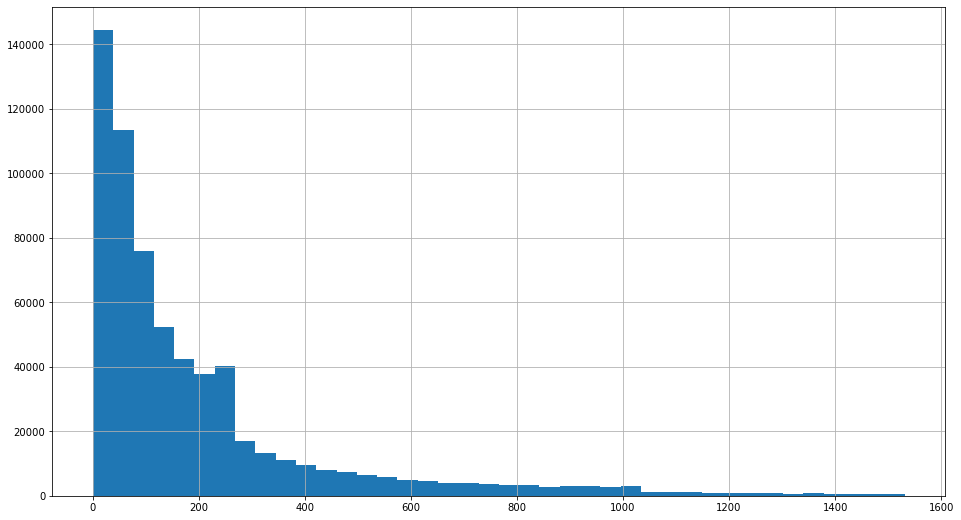

In [44]:
textLengthHistPlotter()

## Extract Social Graph Data

In [45]:
def resolveUrl(completeUrl):
    
    if "bit.ly" in completeUrl:

        if(gloCheckIsAlreadyCached("resolved-urls.csv", completeUrl)):
            return gloGetCached("resolved-urls.csv", completeUrl)
        else:
            print("Resolve now >>" + completeUrl + "<<")
            try:
                r = requests.get(completeUrl, timeout = 5)
                u = r.url
                gloAddToCache("resolved-urls.csv", completeUrl, u)
                return u
            except:
                print("- Warn: Can not resolve (return completeUrl)")
                return completeUrl

    else:
        return completeUrl

In [46]:
# TODO: Extract hashtags in non formatted text

def extractImportantHashtags(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.astype(str)["procTDHashtags"] != "[]"] #TODO: Add eval

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["procTDHashtags"]:
            hashTagList.append(hashtagItem)

    return hashTagList

In [47]:
# TODO: Bug: No Hostname detected if string startsWith ! "http" in urlparse
# TODO: Feature: Url in non formatted text?
# TODO: Feature: Add other attributes (e.g. hashtags)
# TODO: Feature: Cache-Layer: Check if both set (from and from_id, actor, ...)
# TODO: Check: Duplicates refs from text

# TODO: Doc: Text ref important for finding groups
# TODO: Doc: forwared_from important for graphs

# Returns
# a = Counter forwardedFromList
# b = Counter refList
# c = Counter hashtagList
def extractSocialGraph(filePath, debugPrint):
    dfMessages = dictMessages[filePath].copy()

    hostList = list()
    urList   = list()
    urlResolvedList = list()
    refList = list()
    for index, row in dfMessages.iterrows():
        if(str(row["procTDURLs"]) != "[]"): #TODO: Add eval
            for urlItem in row["procTDURLs"]:
                urlData = urlparse(str(urlItem))

                completeHostname = urlData.hostname
                completeUrl      = urlData.geturl()

                hostList.append(str(completeHostname))
                urList.append(str(completeUrl))
                urlResolvedList.append(str(resolveUrl(completeUrl)))

                if "t.me" in str(completeHostname):
                    refList.append(str(completeUrl))
            
    forwardedFromList = list()
    if("forwarded_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():        
            forwardedFromList.append(str(row["forwarded_from"]))
            
    actorList = list()
    if("actor" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            actorList.append(str(row["actor"]))
    
    memberList = list()
    if("members" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            if(str(row["members"]) != "nan"):
                for memberItem in row["members"]:
                    memberList.append(str(memberItem))
                    
    fromList = list()
    if("from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            fromList.append(str(row["from"]))
            
    savedFromList = list()
    if("saved_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            savedFromList.append(str(row["saved_from"]))

    hashtagList = extractImportantHashtags(filePath)
    
    configTopN = 5

    if(debugPrint):
        print("- Top Hosts -")
        print ("\n".join(map(str, Counter(hostList).most_common(configTopN))))
        print()
        print("- Top URLs -")
        print ("\n".join(map(str, Counter(urList).most_common(configTopN))))
        print()
        print("- Top URLs resolved -")
        print ("\n".join(map(str, Counter(urlResolvedList).most_common(configTopN))))
        print()
        print("- Top Refs from text -")
        print ("\n".join(map(str, Counter(refList).most_common(configTopN))))
        print()
        print("- Top Refs (forwarded_from) -")
        print ("\n".join(map(str, Counter(forwardedFromList).most_common(configTopN))))
        print()
        print("- Top Refs (actor) -")
        print ("\n".join(map(str, Counter(actorList).most_common(configTopN))))
        print()
        print("- Top Refs (members) -")
        print ("\n".join(map(str, Counter(memberList).most_common(configTopN))))
        print()
        print("- Top Refs (from) -")
        print ("\n".join(map(str, Counter(fromList).most_common(configTopN))))
        print()
        print("- Top Refs (saved_from) -")
        print ("\n".join(map(str, Counter(savedFromList).most_common(configTopN))))
        print()
        print("- Top hashtags -")
        print ("\n".join(map(str, Counter(hashtagList).most_common(configTopN))))
        print()
    
    return (Counter(forwardedFromList), Counter(refList), Counter(hashtagList))

In [48]:
dictSGD_ForwardedFrom = {}
dictSGD_Ref           = {}
dictSGD_Hashtag       = {}

gloStartStopwatch("Extract Social Graph Data")

for fP in dfInputFiles.inputPath:

    gloStartStopwatch("Extract Social Graph Data >>" + fP + "<<")

    a, b, c = extractSocialGraph(fP, debugPrint=True)

    dictSGD_ForwardedFrom[fP]   = a
    dictSGD_Ref[fP]             = b
    dictSGD_Hashtag[fP]         = c

    gloStopStopwatch("Extract Social Graph Data >>" + fP + "<<")

gloStopStopwatch("Extract Social Graph Data")

[Stopwatch started >>Extract Social Graph Data<<]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
- Top Hosts -
('youtu.be', 3225)
('t.me', 902)
('www.youtube.com', 578)
('None', 441)
('www.n-tv.de', 315)

- Top URLs -
('www.attilahildmann.de/alles?pc=TOPBIONEU', 106)
('https://bit.ly/37OCsH5', 105)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 69)
('WWW.ATTILAHILDMANN.DE', 61)
('https://demo.terminkalender.top/pc.php', 60)

- Top URLs resolved -
('https://www.attilahildmann.de/de/shop/alle.html?pc=SAMURAI', 106)
('www.attilahildmann.de/alles?pc=TOPBIONEU', 106)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 69)
('WWW.ATTILAHILDMANN.DE', 61)
('https://demo.terminkalender.top/pc.php', 60)

- Top Refs from text -
('https://t.me/ATTILAHILDMANN', 34)
('https://t.me/gerechtigkeitfuersvaterland', 27)
('https://t.me/FreiheitsChatDE', 27)
('https://t.me/NachrichtenWelt', 27)
('https://t.me/FREIHEITS_CHAT_BL', 23)

- Top Refs (forwarded_fr

- Top Hosts -
('www.flickr.com', 3919)
('1.bp.blogspot.com', 411)
('ift.tt', 382)
('None', 244)
('feeds.feedburner.com', 139)

- Top URLs -
('https://www.flickr.com/people/wiedenroth/', 1302)
('www.wiedenroth-karikatur.dewww.wiedenroth-karikatur.de', 224)
('www.wiedenroth-karikatur.de', 12)
('https://de.metapedia.org/wiki/1995', 6)
('https://de.metapedia.org/wiki/2009', 5)

- Top URLs resolved -
('https://www.flickr.com/people/wiedenroth/', 1302)
('www.wiedenroth-karikatur.dewww.wiedenroth-karikatur.de', 224)
('www.wiedenroth-karikatur.de', 12)
('https://de.metapedia.org/wiki/1995', 6)
('https://de.metapedia.org/wiki/2009', 5)

- Top Refs from text -


- Top Refs (forwarded_from) -
('nan', 3040)

- Top Refs (actor) -
('nan', 3039)
('Aktuelle Karikaturen - Götz Wiedenroth - Illustrationen, Cartoons', 1)

- Top Refs (members) -


- Top Refs (from) -
('Aktuelle Karikaturen - Götz Wiedenroth - Illustrationen, Cartoons', 3039)
('nan', 1)

- Top Refs (saved_from) -


- Top hashtags -
('#wirh

Resolve now >>https://bit.ly/2Ocyejp<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/3jus9gs<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/39ZSiiZ<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/39ZSiiZ<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/39ZSiiZ<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/3fHR9PE<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/2Ocyejp<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/3aZXzHf<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/3eo4Q5A<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/2Z5SQzI<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/2QSRljL<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/2I3pkF6<<
- Warn: Can not resolve (return compl

- Top Hosts -
('youtu.be', 133)
('t.me', 75)
('www.bitchute.com', 57)
('wtube.org', 45)
('www.youtube.com', 34)

- Top URLs -
('https://wtube.org/user/DeutschlandVaterland/iDZS0Bz', 9)
('https://wtube.org/user/DeutschlandVaterland/fi7cQYn', 5)
('https://t.me/QAussteiger', 4)
('https://www.fema.gov/news-release/20200727/fema-anuncia-publicacion-de-guia-operacional-para-la-temporada-de-huracanes', 4)
('t.me/boerbouli', 4)

- Top URLs resolved -
('https://wtube.org/user/DeutschlandVaterland/iDZS0Bz', 9)
('https://wtube.org/user/DeutschlandVaterland/fi7cQYn', 5)
('https://t.me/QAussteiger', 4)
('https://www.fema.gov/news-release/20200727/fema-anuncia-publicacion-de-guia-operacional-para-la-temporada-de-huracanes', 4)
('t.me/boerbouli', 4)

- Top Refs from text -
('https://t.me/QAussteiger', 4)
('https://t.me/Anonymous_Germany', 3)
('https://t.me/AnonymousSchweizOrginal', 3)
('https://t.me/antiilluminaten', 3)
('https://t.me/trumpinfo', 2)

- Top Refs (forwarded_from) -
('ATTILA HILDMANN ⚫️

- Top Hosts -
('youtu.be', 2361)
('twitter.com', 2092)
('None', 991)
('www.youtube.com', 942)
('t.me', 793)

- Top URLs -
('https://t.me/epochtimesde', 337)
('https://twitter.com/realDonaldTrump', 99)
('https://t.me/CheckMateNews', 41)
('https://t.me/verbindediepunkte', 20)
('https://verbindediepunkte.de', 20)

- Top URLs resolved -
('https://t.me/epochtimesde', 337)
('https://twitter.com/realDonaldTrump', 99)
('https://t.me/CheckMateNews', 41)
('https://t.me/verbindediepunkte', 20)
('https://verbindediepunkte.de', 20)

- Top Refs from text -
('https://t.me/epochtimesde', 337)
('https://t.me/CheckMateNews', 41)
('https://t.me/verbindediepunkte', 20)
('https://t.me/rabbitresearch', 19)
('https://t.me/TranslatedVideos', 19)

- Top Refs (forwarded_from) -
('nan', 13081)
('Epoch Times Deutschland', 509)
('Oliver Janich öffentlich', 163)
('Qlobal-Change USA 🇺🇸', 97)
('MARKmobil', 67)

- Top Refs (actor) -
('nan', 14924)
('Qlobal-Change 🇩🇪🇦🇹🇨🇭🇱🇮', 21)

- Top Refs (members) -


- Top Refs (fr

Resolve now >>https://bit.ly/39ZSiiZ<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>https://bit.ly/375DTCF<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>bit.ly/39YVBJn<<
- Warn: Can not resolve (return completeUrl)
Resolve now >>bit.ly/38KxEDf<<
- Warn: Can not resolve (return completeUrl)
- Top Hosts -
('t.me', 3681)
('www.youtube.com', 580)
('www.journalistenwatch.com', 239)
('bit.ly', 192)
('uncut-news.ch', 127)

- Top URLs -
('https://t.me/coronainformationskanal', 3513)
('https://corona-ausschuss.de/', 19)
('https://t.me/coronainformationskanal/1548', 19)
('https://t.me/coronainformationskanal/3778', 13)
('https://t.me/coronavirushilfe', 11)

- Top URLs resolved -
('https://t.me/coronainformationskanal', 3513)
('https://corona-ausschuss.de/', 19)
('https://t.me/coronainformationskanal/1548', 19)
('https://t.me/coronainformationskanal/3778', 13)
('https://t.me/coronavirushilfe', 11)

- Top Refs from text -
('https://t.me/coronainformationskanal', 3513)


- Top Hosts -
('youtu.be', 245)
('www.epochtimes.de', 120)
('twitter.com', 111)
('www.youtube.com', 96)
('nypost.com', 66)

- Top URLs -
('https://www.bitchute.com/channel/pIFLS0LFMHHm/', 3)
('https://youtu.be/FeU2LpzJjXE', 2)
('https://www.oliverjanich.de/mega-group-ned-epstein-lauder-palmer-und-nawalny', 2)
('https://youtu.be/kowlJ5VOyik', 2)
('https://youtu.be/ytvSAxrxXu0', 2)

- Top URLs resolved -
('https://www.bitchute.com/channel/pIFLS0LFMHHm/', 3)
('https://youtu.be/FeU2LpzJjXE', 2)
('https://www.oliverjanich.de/mega-group-ned-epstein-lauder-palmer-und-nawalny', 2)
('https://youtu.be/kowlJ5VOyik', 2)
('https://youtu.be/ytvSAxrxXu0', 2)

- Top Refs from text -
('https://t.me/coronainformationskanal', 2)
('https://t.me/epochtimesde', 2)
('https://t.me/EvaHermanOffiziell/15315', 1)
('https://t.me/oliverjanich/26625', 1)
('https://t.me/oliverjanich', 1)

- Top Refs (forwarded_from) -
('nan', 1445)
('Oliver Janich öffentlich', 148)
('Eva Herman Offiziell', 91)
('🇺🇸 US Wahl 2020 - Li

- Top Hosts -
('None', 396)
('t.me', 391)
('youtu.be', 242)
('twitter.com', 92)
('www.youtube.com', 65)

- Top URLs -
('https://t.me/rabbitresearch', 249)
('open.lbry.com/@rabbitresearch:3', 188)
('youtube.com/c/RabbitResearch', 77)
('t.me/FreieMedienTV', 42)
('https://youtu.be/URpuAqgWFYY', 40)

- Top URLs resolved -
('https://t.me/rabbitresearch', 249)
('open.lbry.com/@rabbitresearch:3', 188)
('youtube.com/c/RabbitResearch', 77)
('t.me/FreieMedienTV', 42)
('https://youtu.be/URpuAqgWFYY', 40)

- Top Refs from text -
('https://t.me/rabbitresearch', 249)
('https://t.me/s/rabbitresearch', 17)
('https://t.me/CheckMateNews', 10)
('https://t.me/wahlbetrugUSA', 5)
('https://t.me/weltdergesundheitTV', 3)

- Top Refs (forwarded_from) -
('nan', 891)
('Qlobal-Change 🇩🇪🇦🇹🇨🇭🇱🇮', 61)
('Freie Medien', 47)
('Oliver Janich öffentlich', 37)
('Eva Herman Offiziell', 26)

- Top Refs (actor) -
('nan', 1468)
('RABBIT RESEARCH', 44)

- Top Refs (members) -


- Top Refs (from) -
('RABBIT RESEARCH', 1468)
('n

Resolve now >>https://bit.ly/2Yr5uZz<<
- Warn: Can not resolve (return completeUrl)
- Top Hosts -
('t.me', 993)
('None', 381)
('de.metapedia.org', 303)
('youtu.be', 251)
('www.youtube.com', 113)

- Top URLs -
('t.me/GeheimeswissenderEliten', 82)
('https://T.me/Kinder_schuetzen', 54)
('t.me/Q_D_R_A', 53)
('https://t.me/HolistischeGesundheitHeilung/2801', 37)
('https://t.me/FREIHEITmachtWAHR', 32)

- Top URLs resolved -
('t.me/GeheimeswissenderEliten', 82)
('https://T.me/Kinder_schuetzen', 54)
('t.me/Q_D_R_A', 53)
('https://t.me/HolistischeGesundheitHeilung/2801', 37)
('https://t.me/FREIHEITmachtWAHR', 32)

- Top Refs from text -
('https://T.me/Kinder_schuetzen', 54)
('https://t.me/HolistischeGesundheitHeilung/2801', 37)
('https://t.me/FREIHEITmachtWAHR', 32)
('https://t.me/EuLzL', 24)
('http://t.me/GeheimeswissenderEliten', 19)

- Top Refs (forwarded_from) -
('nan', 5284)
('🚨Freiheit macht Wahr, Wahrheit macht Frei 🚨', 415)
('🌍 Verschwörungen 🌍', 373)
('Q Digital Research Area', 243)
('

Resolve now >>http://bit.ly/steripen-classic<<
- Warn: Can not resolve (return completeUrl)
- Top Hosts -
('t.me', 661)
('connectiv.events', 295)
('bit.ly', 169)
('www.youtube.com', 153)
('None', 52)

- Top URLs -
('https://t.me/Daniel_Prinz_Offiziell', 433)
('https://t.me/daniel_prinz_offiziell', 15)
('https://t.me/antiilluminaten', 11)
('t.me/FreieMedienTV', 10)
('https://t.me/ConnectivEvents', 10)

- Top URLs resolved -
('https://t.me/Daniel_Prinz_Offiziell', 433)
('https://t.me/daniel_prinz_offiziell', 15)
('https://t.me/antiilluminaten', 11)
('t.me/FreieMedienTV', 10)
('https://t.me/ConnectivEvents', 10)

- Top Refs from text -
('https://t.me/Daniel_Prinz_Offiziell', 433)
('https://t.me/daniel_prinz_offiziell', 15)
('https://t.me/antiilluminaten', 11)
('https://t.me/ConnectivEvents', 10)
('https://t.me/Daniel_Prinz_Offiziell/1223', 6)

- Top Refs (forwarded_from) -
('nan', 1188)
('Globales Erwachen - Weltgeschehen, Gesundheit und Neues Zeitalter', 149)
('Das Prinz Telegramm', 98)


### Get Top Influencer (Downloaded?)

In [49]:
# Get Top Influencer
# param fPList      filePath List
# param configTopN  Get Top n influencer e.g. 10
def getTopInfluencer(fPList, configTopN):

    for fP in fPList:

        chatName = queryChatName(fP)

        print()
        print("Analyse Chat (Forwarded From) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_ForwardedFrom[fP]
        socialGraphData = socialGraphData.most_common(configTopN +1) #Add 1 (nan values)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # Already downloaded?
            flagDownloaded = False
            if oChatName in dfQueryMeta.qryChatName.values:
                flagDownloaded = True

            if(oChatName != "nan"):

                print(str(counter) + ": (downloaded=" + str(flagDownloaded) + ") (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1


        print()
        print("Analyse Chat (Refs) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_Ref[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = str(oChatName)
            oChatRefs    = oChatRefs

            if(oChatName != "nan"):

                print(str(counter) + " (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1

In [50]:
getTopInfluencer(list(dfInputFiles[dfInputFiles.inputDesc == "stage0"].inputPath), 10)


Analyse Chat (Forwarded From) >>ATTILA HILDMANN <<
1: (downloaded=True) (refs=7448)		>>ATTILA HILDMANN <<
2: (downloaded=True) (refs=616)		>>Gerechtigkeit fr das Vaterland<<
3: (downloaded=True) (refs=44)		>>Aktuelle Karikaturen - Gtz Wie<<
4: (downloaded=True) (refs=41)		>>.   <<
5: (downloaded=False) (refs=38)		>>Anonymous Germany<<
6: (downloaded=True) (refs=34)		>>MICHAEL WENDLER <<
7: (downloaded=True) (refs=33)		>>Oliver Janich ffentlich<<
8: (downloaded=True) (refs=28)		>>Laser Lurch<<
9: (downloaded=True) (refs=28)		>>Dawid Snowden<<
10: (downloaded=True) (refs=26)		>>Ken Jebsen - Aufklrung und Inf<<

Analyse Chat (Refs) >>ATTILA HILDMANN <<
1 (refs=34)		>>https://t.me/ATTILAHILDMANN<<
2 (refs=27)		>>https://t.me/gerechtigkeitfuersvaterland<<
3 (refs=27)		>>https://t.me/FreiheitsChatDE<<
4 (refs=27)		>>https://t.me/NachrichtenWelt<<
5 (refs=23)		>>https://t.me/FREIHEITS_CHAT_BL<<
6 (refs=21)		>>https://t.me/DEMOKRATENCHAT<<
7 (refs=20)		>>https://t.me/ChatDerFreiheit<<
8 (refs

In [51]:
getTopInfluencer(list(dfInputFiles[dfInputFiles.inputDesc == "stage1"].inputPath), 5)


Analyse Chat (Forwarded From) >>Gerechtigkeit fr das Vaterland<<
1: (downloaded=True) (refs=103)		>>Gerechtigkeit fr das Vaterland<<
2: (downloaded=False) (refs=20)		>>Wahrheit oder Wahnsinn<<
3: (downloaded=True) (refs=18)		>>AugenAuf<<
4: (downloaded=False) (refs=14)		>>Anti-Antifa Germany<<
5: (downloaded=False) (refs=12)		>>Zndel's Bunker<<

Analyse Chat (Refs) >>Gerechtigkeit fr das Vaterland<<
1 (refs=13)		>>https://t.me/gerechtigkeitfuersvaterland<<
2 (refs=5)		>>https://t.me/coronainformationskanal<<
3 (refs=3)		>>https://t.me/JewrassicLiars<<
4 (refs=1)		>>https://t.me/FREIHEITSCHAT2020<<
5 (refs=1)		>>https://t.me/corona_leaks<<

Analyse Chat (Forwarded From) >>Aktuelle Karikaturen - Gtz Wie<<

Analyse Chat (Refs) >>Aktuelle Karikaturen - Gtz Wie<<

Analyse Chat (Forwarded From) >>.   <<
1: (downloaded=False) (refs=30)		>>COMPACT-Magazin<<
2: (downloaded=True) (refs=23)		>>Oliver Janich ffentlich<<
3: (downloaded=False) (refs=18)		>>reitschuster.de<<
4: (downloaded=False) (r


Analyse Chat (Forwarded From) >> Verschwrungen <<
1: (downloaded=False) (refs=415)		>>Freiheit macht Wahr, Wahrheit <<
2: (downloaded=True) (refs=373)		>> Verschwrungen <<
3: (downloaded=False) (refs=243)		>>Q Digital Research Area<<
4: (downloaded=True) (refs=118)		>>Xavier Naidoo (inoffiziell)<<
5: (downloaded=False) (refs=113)		>>INTO THE LIGHT  BERBLICK & NEW<<

Analyse Chat (Refs) >> Verschwrungen <<
1 (refs=54)		>>https://T.me/Kinder_schuetzen<<
2 (refs=37)		>>https://t.me/HolistischeGesundheitHeilung/2801<<
3 (refs=32)		>>https://t.me/FREIHEITmachtWAHR<<
4 (refs=24)		>>https://t.me/EuLzL<<
5 (refs=19)		>>http://t.me/GeheimeswissenderEliten<<

Analyse Chat (Forwarded From) >>Flache Erde Deutschland <<
1: (downloaded=False) (refs=69)		>>Markus Mller | Feed<<
2: (downloaded=False) (refs=31)		>>Yoice.net<<
3: (downloaded=True) (refs=23)		>>Flache Erde Deutschland <<
4: (downloaded=True) (refs=20)		>>Xavier Naidoo (inoffiziell)<<
5: (downloaded=False) (refs=15)		>>Sven Liebich Kanal

### Plot Social Graph

In [52]:
# Add node weight to dict
# Only adds new weight if newWeight > oldWeight
def addSocialGraphNodeWeight(chatName, chatWeight, targetDict):
    
    if(chatName in targetDict):
        oldWeight = targetDict[chatName]
        if(chatWeight > oldWeight):
            targetDict[chatName] = chatWeight
    else:
        targetDict[chatName] = chatWeight

In [53]:
"""
Generate social graph

param   configTopNInfluencer    e.g. For top 10 = 10
param   configMinRefs           e.g. 1 must have > 1 % forwarded messages
param   listFilePaths           List process filePaths
"""
def generateSocialGraph(configTopNInfluencer, configMinRefs, listFilePaths):
    
    # Save node weights to dict
    dictSocialNodeWeights   = dict()

    # Flag downloaded nodes (exact node weight)
    listExactNodeWeights    = list()
    
    gloStartStopwatch("Social Graph")
    
    # Generate directed graph
    G_weighted = nx.DiGraph()
    
    print("- Add edges")
    for fP in listFilePaths:
        
        # Query own params
        chatName                        = queryChatName(fP)
        chatNumberOfMessages            = queryNumberOfMessages(fP)
        chatNumberOfForwardeMessages    = queryNumberOfForwardedMessages(fP)

        gloStartStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfMessages) + " messages)")
        
        # Add exact node size (chat downloaded) and flag node
        addSocialGraphNodeWeight(chatName, chatNumberOfMessages, dictSocialNodeWeights)
        listExactNodeWeights.append(chatName)

        # Extract social graph data and get top influencer
        socialGraphData = dictSGD_ForwardedFrom[fP]
        socialGraphData = socialGraphData.most_common(configTopNInfluencer)
        
        # Iterate over forwarder
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # If has forwarder
            if(oChatName != "nan"):
        
                # Calc percent (forwarded_messages)
                per = (oChatRefs/chatNumberOfForwardeMessages) * 100

                # Filter unimportant forwarders
                if(per > configMinRefs):
                
                    # Add estimanted node size (chat not downloaded)
                    addSocialGraphNodeWeight(oChatName, oChatRefs, dictSocialNodeWeights)

                    # Invert percent (distance)
                    wei = 100 - per

                    # Add edge
                    G_weighted.add_edge(
                        chatName,
                        oChatName,
                        weight=wei,
                        tLabel = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfForwardeMessages) + "≙" + str(round(wei, 3)) + ")"
                    )

        gloStopStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfMessages) + " messages)")
        
    print("- Add different nodes")
    for aNode in dictSocialNodeWeights:
        
        # Query node params
        nodeName   = str(aNode)
        nodeWeight = dictSocialNodeWeights[aNode]

        # Set default color
        tValueColor = "#ff8000"

        # Overwrite (if chat downloaded = exact weight)
        if(nodeName in listExactNodeWeights):
            tValueColor = "#0080ff"
        
        G_weighted.add_node(
            nodeName,
            weight=nodeWeight,
            tLabel = str(nodeName) + " [" + str(nodeWeight) + "]",
            tColor=tValueColor
        )
        
    gloStopStopwatch("Social Graph")
        
    return G_weighted

In [54]:
# TODO: Test different layouts: https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
# TODO: Try different arrows (see below): https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.ArrowStyle.html
# TODO: Check distances between nodes

"""
Draw social grah

param   G                           graph
param   configFactorEdge            e.g. 100 => weight / 100
param   configFactorNode            e.g. 10  => weight / 10
param   configArrowSize             e.g. 5
param   configPlotWidth             e.g. 16
param   configPlotHeight            e.g. 9
param   outputFilename              e.g. test.png
"""
def drawSocialGraph(G, configFactorEdge, configFactorNode, configArrowSize, configPlotWidth, configPlotHeight, outputFilename):
    
    gloStartStopwatch("Social Graph Plot")
    
    plt.figure(figsize=(configPlotWidth,configPlotHeight))
        
    #pos = nx.nx_pydot.graphviz_layout(G)
    #pos = nx.spring_layout(G.to_undirected(), k = 0.15, iterations=200)
    pos = nx.kamada_kawai_layout(G.to_undirected())
    
    # Clean edges
    edges       = nx.get_edge_attributes(G, "weight")
    edgesTLabel = nx.get_edge_attributes(G, "tLabel")

    clean_edges         = dict()
    clean_edges_labels  = dict()
    
    for key in edges:
        
        #Set edge weight
        clean_edges[key]        = (100 - edges[key]) / configFactorEdge

        #set edge layout
        clean_edges_labels[key] = edgesTLabel[key]
    
    # Clean nodes
    nodes       = nx.get_node_attributes(G,'weight')
    nodesTLabel = nx.get_node_attributes(G,'tLabel')
    nodesTColor = nx.get_node_attributes(G,'tColor')

    clean_nodes         = dict()
    clean_nodes_labels  = dict()
    clean_nodes_color   = dict()
    
    for key in nodes:
        
        #Set node weight        
        clean_nodes[key]        = nodes[key] / configFactorNode

        #Set node layout
        clean_nodes_labels[key] = nodesTLabel[key]
        clean_nodes_color[key]  = nodesTColor[key]
    
    # Revert DiGraph (arrows direction)
    G_rev = nx.DiGraph.reverse(G)    

    # Draw
    nx.draw(G_rev,
        pos,
        with_labels=True,
        width=list(clean_edges.values()),
        node_size=list(clean_nodes.values()),
        labels=clean_nodes_labels,
        node_color=list(clean_nodes_color.values()),
        arrowsize=configArrowSize,
        arrowstyle="wedge"
        #connectionstyle="arc3, rad = 0.1"
    )
    
    # Set labels
    _ = nx.draw_networkx_edge_labels(G_rev, pos, edge_labels=clean_edges_labels)

    # Save and show fig
    plt.savefig(dir_var_output + outputFilename)
    plt.show()
    
    gloStopStopwatch("Social Graph Plot")

#### Test Graph

[Stopwatch started >>Social Graph Plot<<]


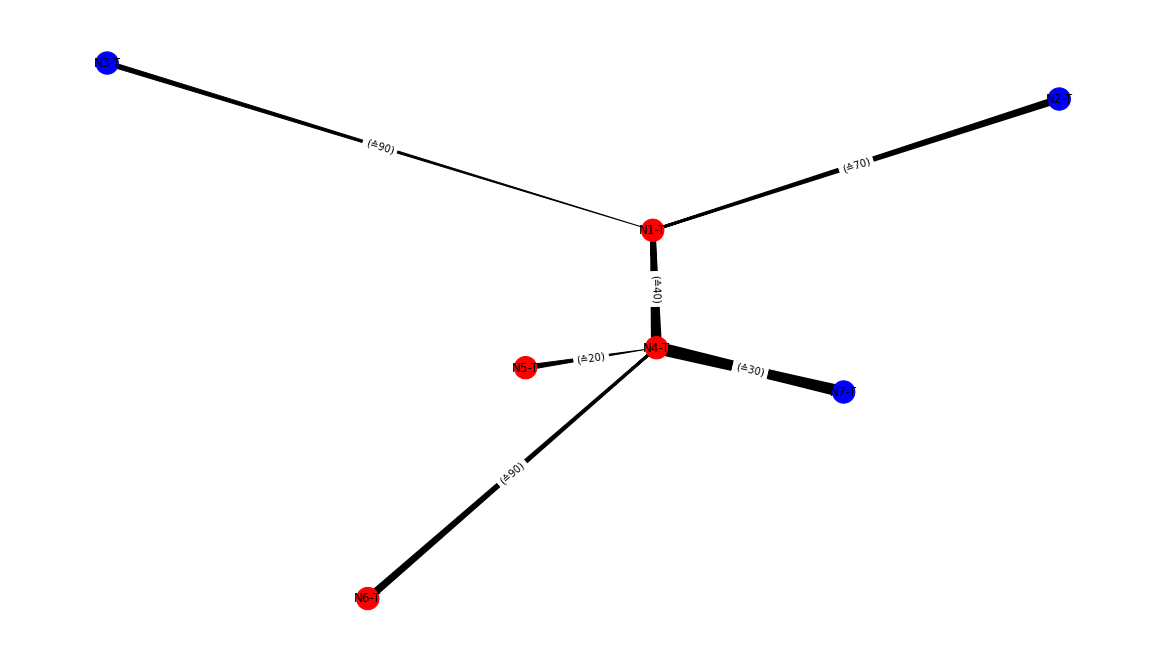

[Stopwatch stopped >>Social Graph Plot<< (0.402s)]


In [55]:
# Generates Test Graph
def generateTestGraph():

    G_weighted = nx.DiGraph()

    G_weighted.add_edge("N1", "N2", weight=100-30,  tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N1", "N3", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")
    G_weighted.add_edge("N1", "N4", weight=100-60,  tLabel = "(≙" + str(100-60) + ")")

    G_weighted.add_edge("N4", "N5", weight=100-80,  tLabel = "(≙" + str(100-80) + ")")
    G_weighted.add_edge("N4", "N6", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")

    G_weighted.add_edge("N4", "N7", weight=100-30,   tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N7", "N4", weight=100-70,   tLabel = "(≙" + str(100-70) + ")")

    G_weighted.add_node("N1", weight=500.0, tLabel = "N1-T", tColor="red")
    G_weighted.add_node("N2", weight=500.0, tLabel = "N2-T", tColor="blue")
    G_weighted.add_node("N3", weight=500.0, tLabel = "N3-T", tColor="blue")
    G_weighted.add_node("N4", weight=500.0, tLabel = "N4-T", tColor="red")
    G_weighted.add_node("N5", weight=500.0, tLabel = "N5-T", tColor="red")
    G_weighted.add_node("N6", weight=500.0, tLabel = "N6-T", tColor="red")
    G_weighted.add_node("N7", weight=500.0, tLabel = "N7-T", tColor="blue")

    return G_weighted

generatedTestGraph = generateTestGraph()

drawSocialGraph(
    generatedTestGraph,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 16,
    configPlotHeight = 9,
    outputFilename = "social-test-graph.png"
)

#### Real Graph

In [56]:
generatedSocialGraph = generateSocialGraph(
    configTopNInfluencer = 500,  # TODO: Set param
    configMinRefs = 1,         # TODO: Set param
    listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "stage0"].inputPath)
    #listFilePaths = list(dfInputFiles.inputPath)
)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (37612 messages)<< (0.000s)]
[Stopwatch started >>SG-Extract Oliver Janich ffentlich(47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich ffentlich(47026 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(36523 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Xavier Naidoo (inoffiziell)(12214 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo (inoffiziell)(12214 messages)<< (0.001s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.310s)]


[Stopwatch started >>Social Graph Plot<<]


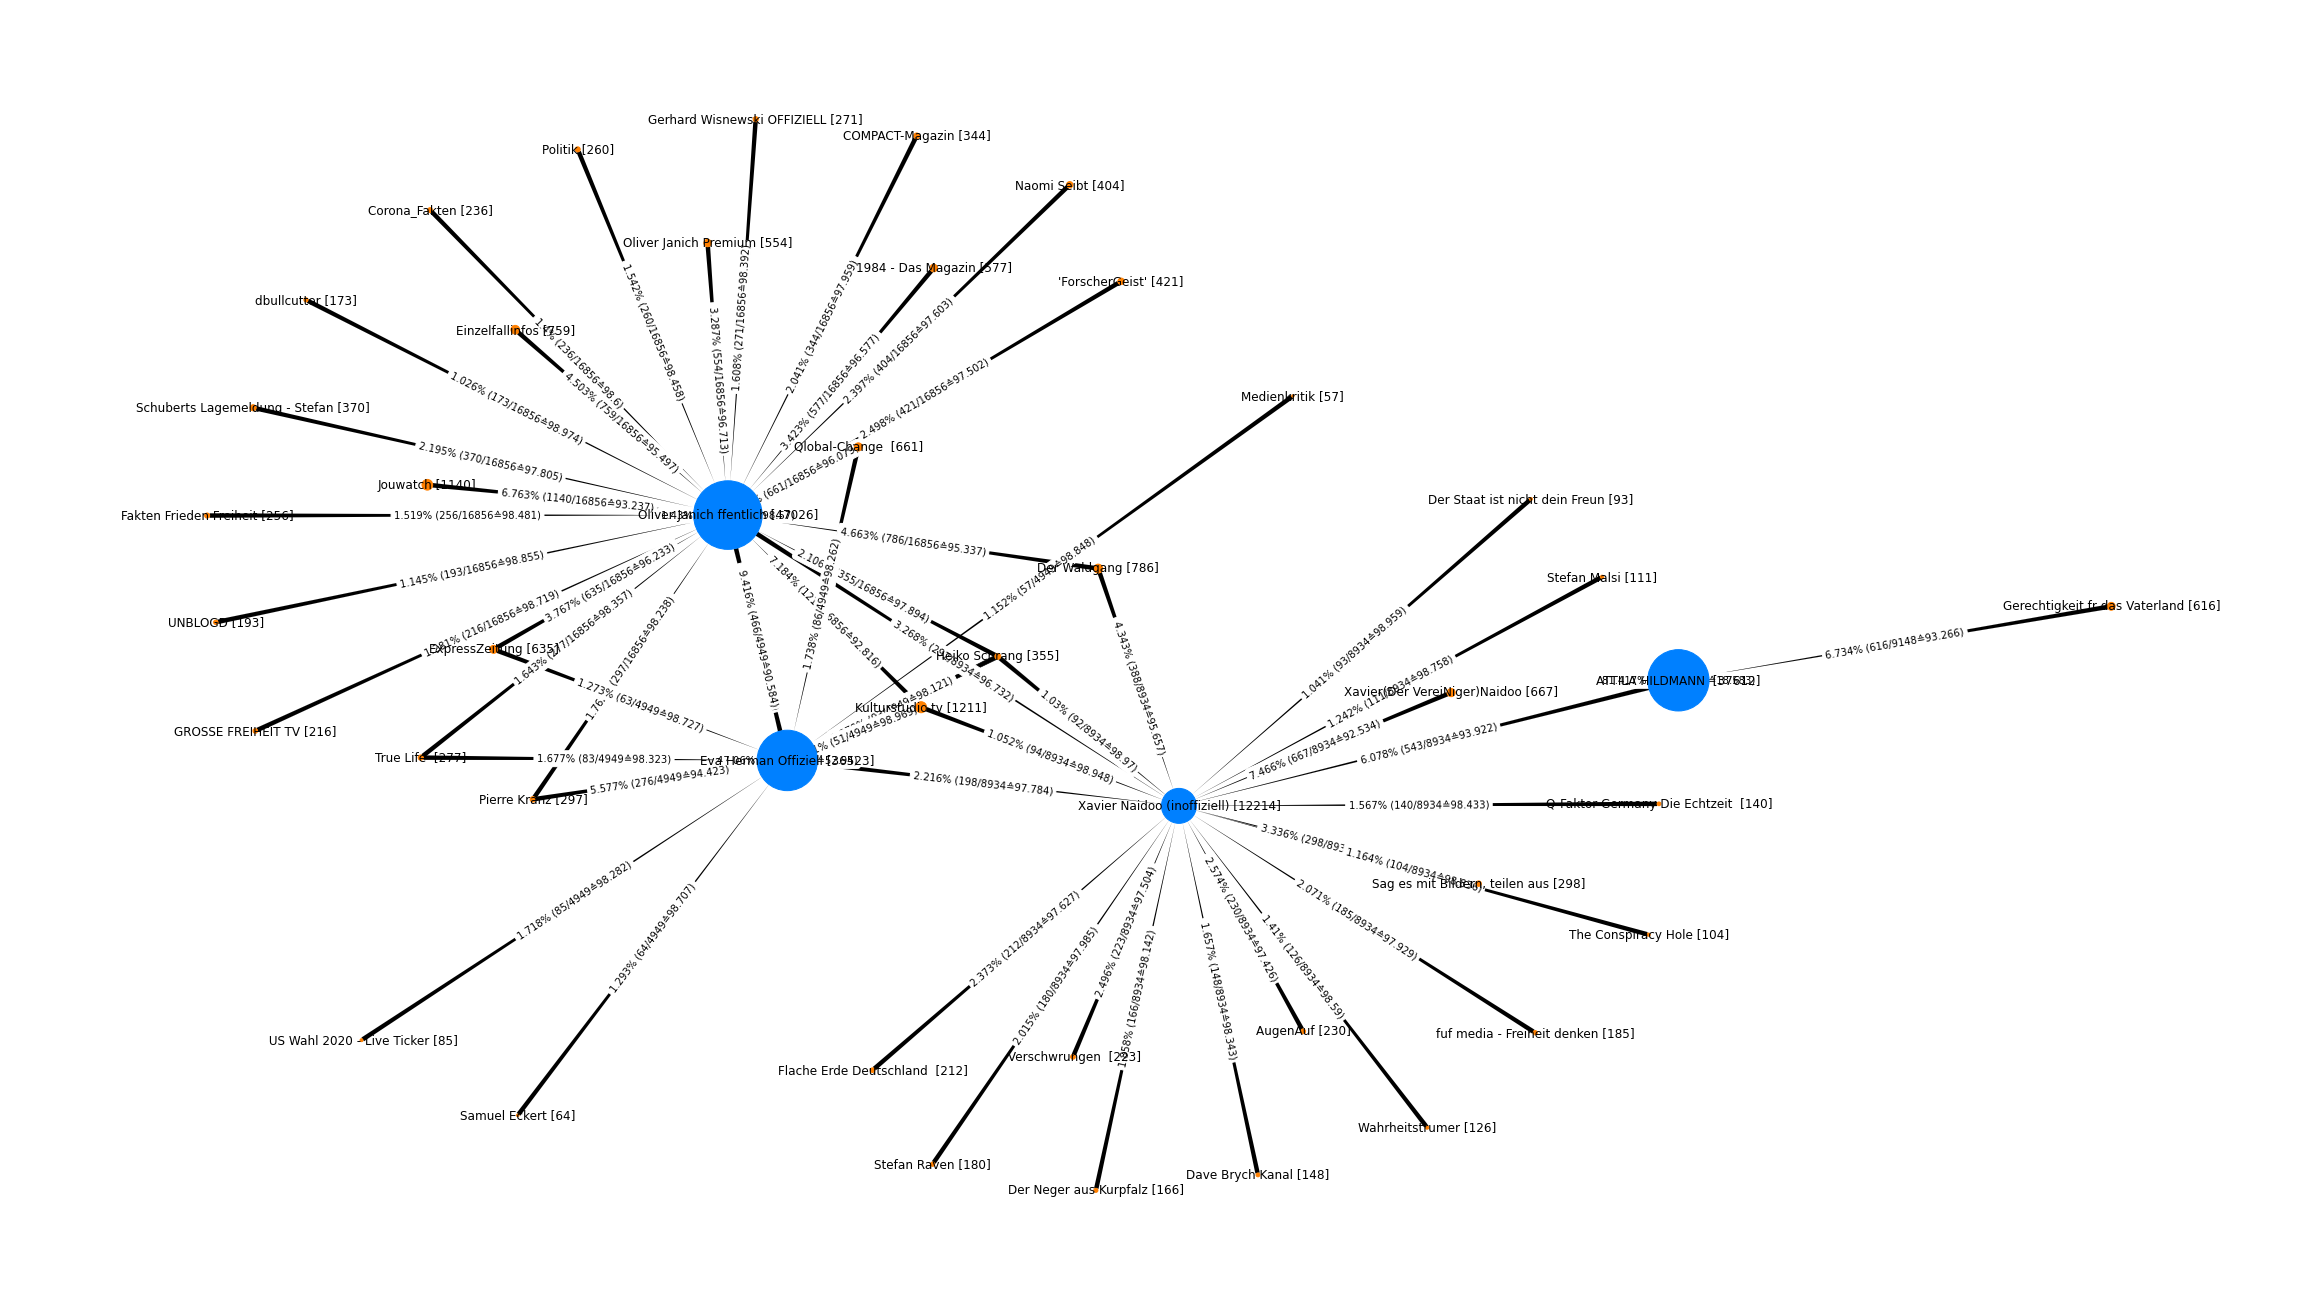

[Stopwatch stopped >>Social Graph Plot<< (2.437s)]


In [57]:
# TODO: Add Hashtag graph (see social-hashtag-graph.png)
drawSocialGraph(
    generatedSocialGraph,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 18,
    outputFilename = "social-graph.png"
)

## Word Clouds

In [58]:
# TODO: Difference capital letters?
# TODO: Context?
# TODO: Improve stop words
# TODO: Only on valid text?

"""
WordCloud

param   filePath    String (set to "global" if you want to process all messages)
param   label       filename in outputdir
param   filterList  Exclude list
"""
def generateWordCloud(filePath, label, filterList):
    
    gloStartStopwatch("Word Cloud")

    # Get data
    if(filePath != "global"):
        dfMessages = dictMessages[filePath].copy()
    else:
        dfMessages = dfAllDataMessages.copy()
    
    # Iterate over text (global text from group)
    print("- Start transform text to global text string")
    textList = []
    for index, row in dfMessages.iterrows():
        textList.append(" " + row["procTDText"])
        
    textString = ''.join(textList)
    
    # Get StopWords and add custom words
    germanStopWordsList = nltk.corpus.stopwords.words('german')
    germanStopWordsList.append("http")
    germanStopWordsList.append("https")
    germanStopWordsList.append("ja")
    germanStopWordsList.append("nein")
    germanStopWordsList.append("mehr")
    germanStopWordsList.append("mal")
    germanStopWordsList.append("schon")
    germanStopWordsList.append("immer")
    germanStopWordsList.append("wurde")
    germanStopWordsList.append("wurden")
    germanStopWordsList.append("sei")
    germanStopWordsList.append("sein")
    germanStopWordsList.append("viel")
    germanStopWordsList.append("viele")
    germanStopWordsList.append("wegen")
    germanStopWordsList.append("müssen")
    germanStopWordsList.append("geht")
    germanStopWordsList.append("gibt")
    germanStopWordsList.append("wer")
    germanStopWordsList.append("wie")
    germanStopWordsList.append("was")
    germanStopWordsList.append("macht")
    germanStopWordsList.append("machen")
    germanStopWordsList.append("machte")
    germanStopWordsList.append("kommen")
    germanStopWordsList.append("kommt")
    germanStopWordsList.append("glaube")
    germanStopWordsList.append("glaubst")
    germanStopWordsList.append("tun")
    germanStopWordsList.append("wäre")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sagten")
    germanStopWordsList.append("hat")
    germanStopWordsList.append("hast")
    germanStopWordsList.append("haben")
    germanStopWordsList.append("habt")
    germanStopWordsList.append("statt")
    germanStopWordsList.append("genau")
    germanStopWordsList.append("sagen")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sagten")
    germanStopWordsList.append("bitte")
    germanStopWordsList.append("bitten")
    germanStopWordsList.append("danke")
    germanStopWordsList.append("dank")
    germanStopWordsList.append("sollen")
    germanStopWordsList.append("soll")
    germanStopWordsList.append("sollte")
    germanStopWordsList.append("sehen")
    germanStopWordsList.append("seht")
    germanStopWordsList.append("zeigen")
    germanStopWordsList.append("zeigt")
    germanStopWordsList.append("sei")
    germanStopWordsList.append("sein")
    germanStopWordsList.append("seid")
    germanStopWordsList.append("seit")
    germanStopWordsList.append("laut")
    germanStopWordsList.append("lauten")
    germanStopWordsList.append("sehen")
    germanStopWordsList.append("seht")
    germanStopWordsList.append("haben")
    germanStopWordsList.append("hat")
    germanStopWordsList.append("hätten")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sag")
    germanStopWordsList.append("sagt")
    germanStopWordsList.append("ab")
    germanStopWordsList.append("bei")
    germanStopWordsList.append("beim")
    germanStopWordsList.append("denen")
    germanStopWordsList.append("gab")
    germanStopWordsList.append("ab")
    
    for fItem in filterList:
        germanStopWordsList.append(fItem)
    
    # Generate word cloud and save it to file
    print("- Start generate cloud")
    wordcloud = WordCloud(
                background_color="black",
                width=1920,
                height=1080,
                stopwords=germanStopWordsList
            ).generate(textString)
    wordcloud.to_file(dir_var_output + "wordcloud-" + label + ".png")
    
    # Show top 20
    print()
    print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
    print()
    
    # Show word cloud
    print("- Start generate figure")
    plt.figure(figsize=(14, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    
    gloStopStopwatch("Word Cloud")

In [59]:
# Oliver Janich öffentlich (public_channel)
#generateWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-25-janich",
#    "pc-janich",
#    []
#)

In [60]:
# Eva Herman Offiziell (public_channel)
#generateWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-27-evaherman",
#    "pc-evaHerman",
#    []
#)

In [61]:
# ATTILA HILDMANN OFFICIAL (public_channel)
#generateWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-25-hildmann",
#    "pc-hildmann",
#    ["ATTILAHILDMANN CHAT"]
#)

In [62]:
# Xavier Naidoo (public_channel)
#generateWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-25-xavier",
#    "pc-xavier",
#    ["xavier_naidoo", "Xavier_Naidoo", "politische_bildersprueche", "einmal_hin_alles_drin"]
#)

[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud

Top 20 occ:
Menschen       1.000000
Deutschland    0.718144
Video          0.544924
Wahrheit       0.536443
heute          0.471920
Berlin         0.422505
Polizei        0.415378
Trump          0.400772
einfach        0.387755
bereit         0.386989
Kinder         0.375239
Warum          0.367082
Welt           0.362076
Leben          0.357010
Corona         0.338958
Leute          0.322143
gut            0.316106
wissen         0.308331
Zeit           0.299231
gerade         0.297347
dtype: float64

- Start generate figure


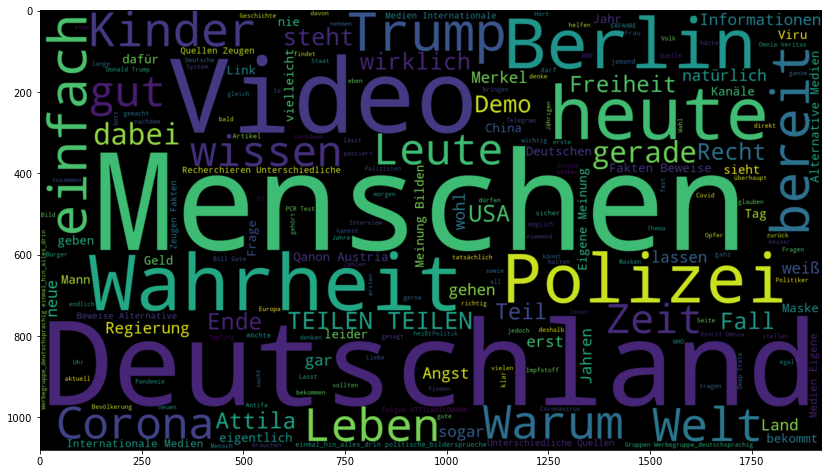

[Stopwatch stopped >>Word Cloud<< (172.083s)]


In [63]:
# Just for test purposes
generateWordCloud(
    "global",
    "global",
    []
)

## Test Stuff

In [64]:
#from ipywidgets import interact
#import ipywidgets as widgets

In [65]:
#interact(plot_random_graph, n=(2,30), m=(1,10), k=(1,10), p=(0.0, 1.0, 0.001),
#         generator={
#             'lobster': random_lobster,
#             'power law': powerlaw_cluster,
#             'Newman-Watts-Strogatz': newman_watts_strogatz,
#             u'Erdős-Rényi': erdos_renyi,
#         });

### Concordance

In [66]:
#tbd